In [245]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("gabrielmanfredi/football-players-ratings")
#print("Path to dataset files:", path)

# Importation des packages et du Dataset

In [246]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [247]:
df = pd.read_csv('data_football_ratings.csv')

# Découverte du Dataset

# Statistiques descriptives

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked            50652 non-null

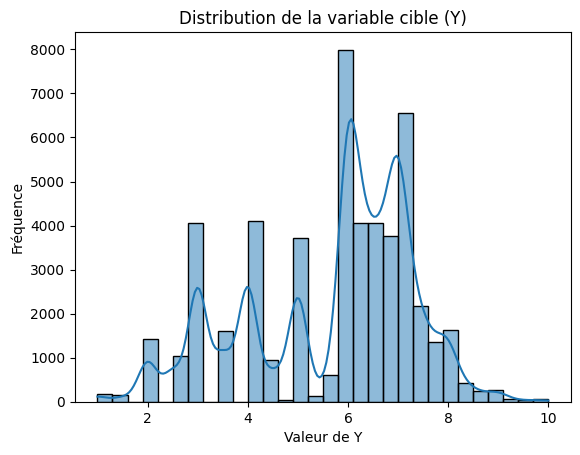

In [249]:
sns.histplot(df['original_rating'], kde=True, bins=30)
plt.title("Distribution de la variable cible (Y)")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

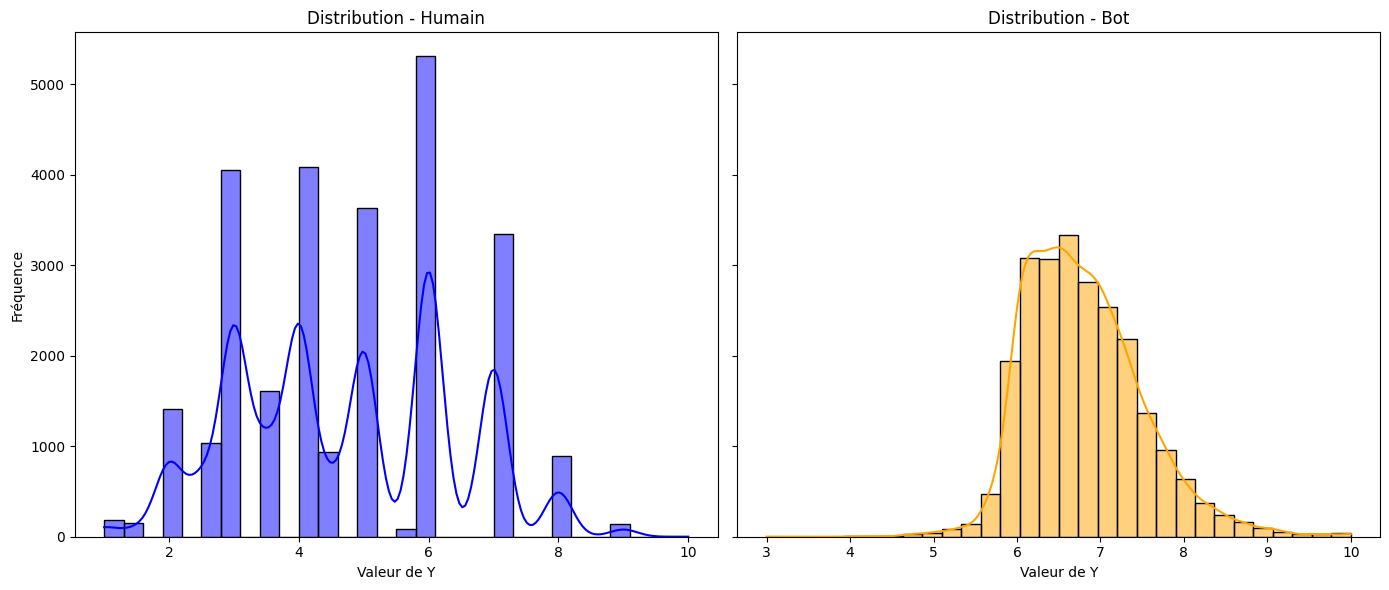

In [250]:
df_human = df[df['is_human']==1]
df_bot = df[df['is_human']==0]

# Créer un subplot avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Distribution des humains
sns.histplot(df_human['original_rating'], kde=True, bins=30, ax=axes[0], color='blue')
axes[0].set_title("Distribution - Humain")
axes[0].set_xlabel("Valeur de Y")
axes[0].set_ylabel("Fréquence")

# Distribution des bots
sns.histplot(df_bot['original_rating'], kde=True, bins=30, ax=axes[1], color='orange')
axes[1].set_title("Distribution - Bot")
axes[1].set_xlabel("Valeur de Y")

plt.tight_layout()
plt.show()

Il est intéressant d'observer que les bots ont tendances à attribuer des notes élevées avec une distribution en cloche et avec peu de disparitées (s'expliquant par un éventuel biais auto entretenu?) tandis la notation humaine contient plus de disparité et est souvent discrète.

In [251]:
df['rater'].unique()

array(['Kicker', 'WhoScored', 'SofaScore', 'TheGuardian', 'SkySports',
       'Bild'], dtype=object)

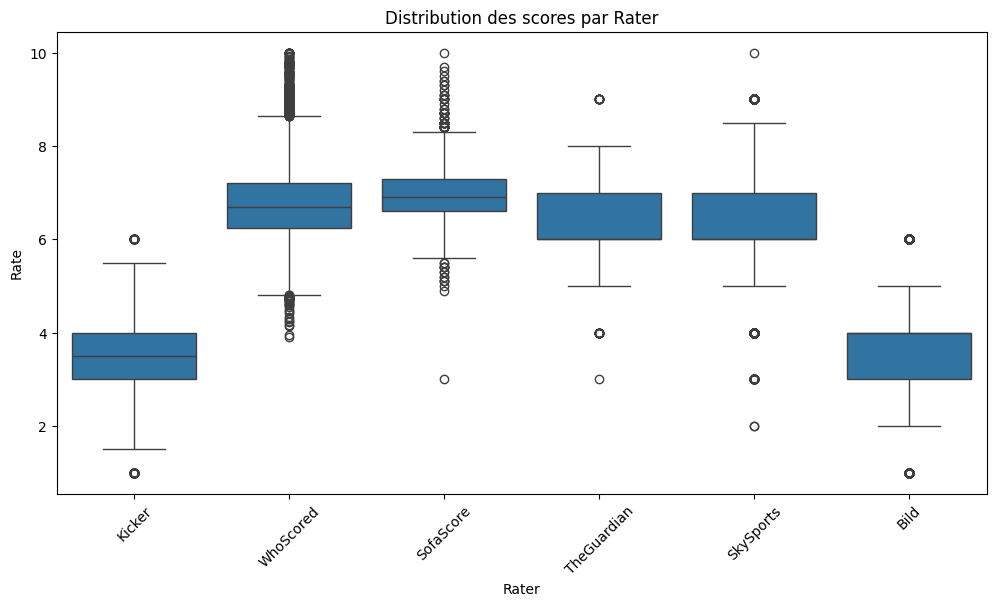

In [252]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rater', y='original_rating')
plt.title('Distribution des scores par Rater')
plt.xlabel('Rater')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

Il est intéressant d'observer qu'il existent des disparitées importantes entre les évaluateurs. Nous pouvons distinguer deux groupes.

In [253]:
#Création de dummies pour retirer les informations des chaines de caractères (compétition, équipe, poste, poste principal ?, évaluateur)
columns_to_dummies = ['competition', 'team', 'pos', 'pos_role', 'rater']
df = pd.get_dummies(df, columns=columns_to_dummies, prefix=columns_to_dummies)

In [254]:
# Nous créons une colonne qui permet de vérifier le nombre d'occurence par joueur
# Cette variable permettra de rendre non sensible nos prédictions à la moyenne car si le joueur apparait une fois il a possibilité d'afficher des performances élevées par chance contrairement aux joueurs jouant plus souvent. Le nombre de fois où un joueur joue peut être signe de bonne perf.

df['nombre_apparitions'] = df['player'].map(df['player'].value_counts())

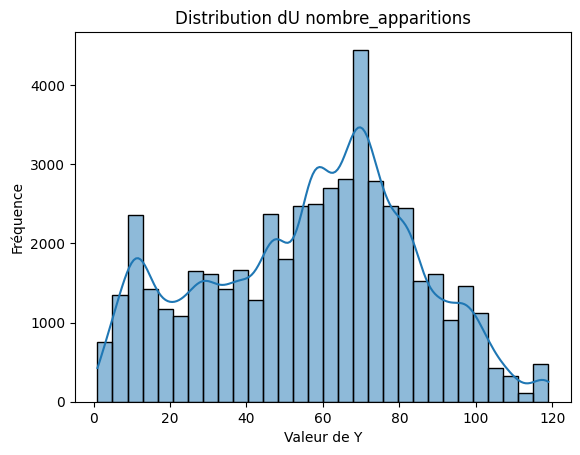

In [289]:
sns.histplot(df['nombre_apparitions'], kde=True, bins=30)
plt.title("Distribution dU nombre_apparitions")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Nous pouvons voir effectivement qu'il y a beaucoup de disparité et qu'il est nécessaire que l'algorithme de prédiction utilisé prennent en compte cette variabilité pour ne pas pénaliser la note prédite d'un joueur qui joue fréquemment.

# Manipulation des tables

Les joueurs étant notés plusieurs fois, nous optons pour établir une moyenne des caractéristiques des joueurs. De ce fait les prédictions de notes de joueurs seront basées sur une moyenne, nous poserons dans un premier temps l'hypothèse forte que les prédicteurs suivent une loi normale et que par conséquent les predictions ne seront pas sensibles aux valeurs extrêmes (d'une autre mesure nous pourrions également jouer sur la médiane).

Nous disposerons donc d'un dataframe avec une ligne par joueur.

In [256]:
df = df.drop(columns=['date', 'match'])

In [257]:
df_avg = df.groupby('player', as_index=False).mean()
df_med = df.groupby('player', as_index=False).median()
print("Nous travaillerons donc avec", len(df_avg), "joueurs")

Nous travaillerons donc avec 1632 joueurs


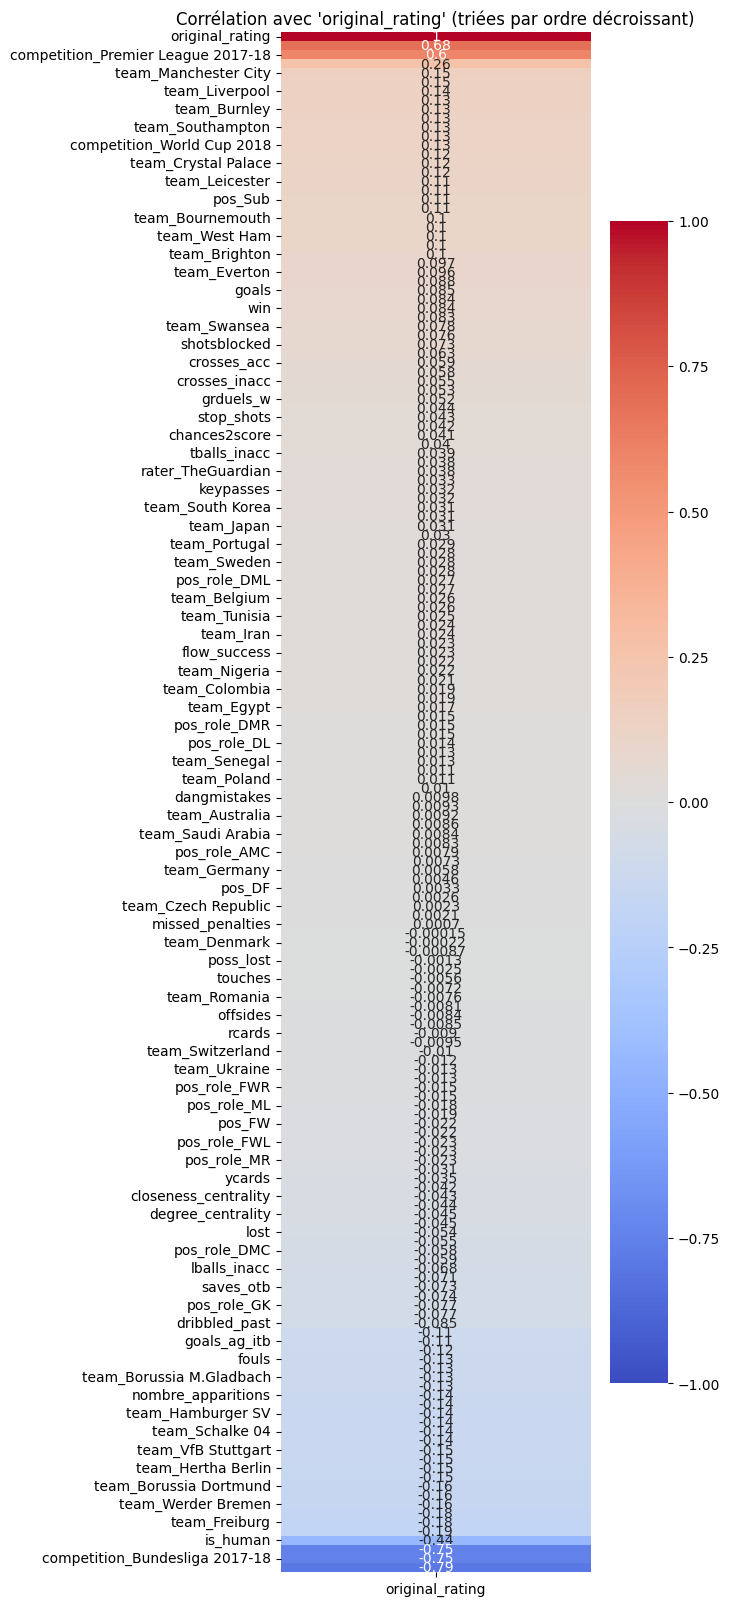

In [258]:
# Exclure la colonne 'player'
df_avg_no_player = df_avg.drop(columns=['player'])

# Calculer la corrélation entre 'original_rating' et les autres variables
correlation = df_avg_no_player.corr()[['original_rating']]

# Trier les corrélations en ordre décroissant
correlation = correlation.sort_values(by='original_rating', ascending=False)

# Créer une heatmap avec seaborn
plt.figure(figsize=(5, 20))  # Taille de la figure
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)

# Ajouter un titre
plt.title("Corrélation avec 'original_rating' (triées par ordre décroissant)")

# Afficher la heatmap
plt.show()

Nous allons opter dans un premier temps sur la sélection des variables avec une corrélation supérieur à 0.1 et inférieur à -0,1

In [259]:
Y = df_avg['original_rating'] #Variable continue
X = df_avg[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

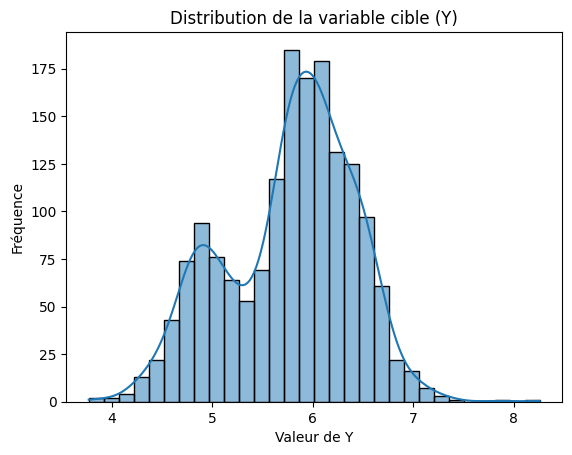

In [260]:
sns.histplot(Y, kde=True, bins=30)
plt.title("Distribution de la variable cible (Y)")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Il est intéressant d'observer que après regroupement par joueurs avec les notes moyennes, nous retrouvons distribution contenant deux groupes:

-Un groupe avec de meilleurs notes (moyenne à 6)

-Un autre groupe avec de moins bonnes notes (moyenne à 4,8)

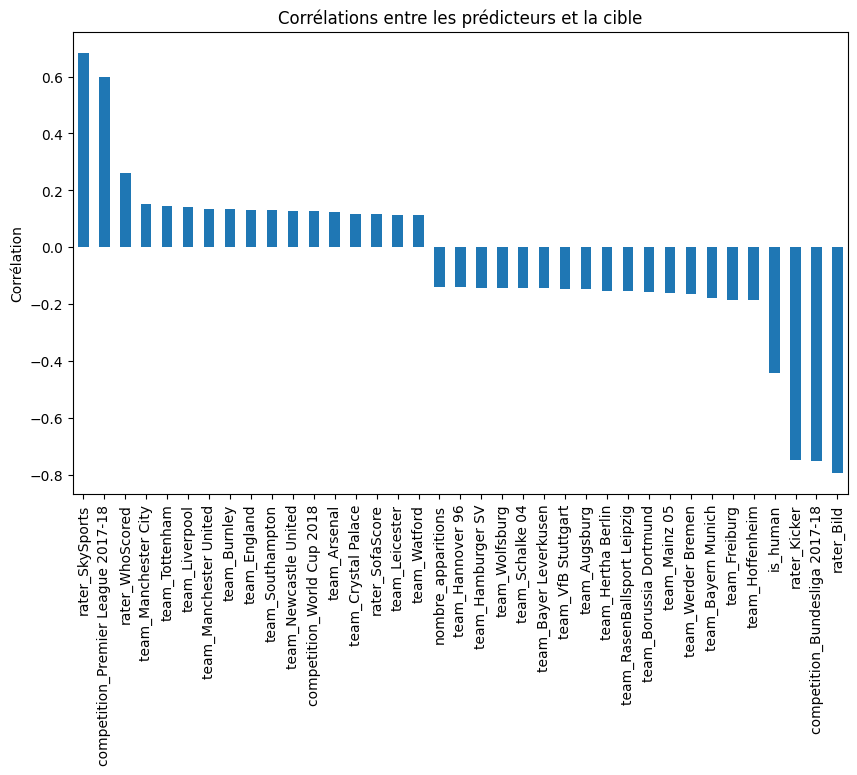

In [261]:
correlations = X.corrwith(Y).sort_values(ascending=False)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title("Corrélations entre les prédicteurs et la cible")
plt.ylabel("Corrélation")
plt.show()